In [1]:
# importing packages
import pandas as pd
import re
import numpy as np
import spacy
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn packages
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics,model_selection, preprocessing,  metrics,naive_bayes, svm,ensemble,model_selection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, fbeta_score,make_scorer ,classification_report



# nltk packages
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from string import punctuation
import unidecode
import contractions



In [2]:
# pre-define item list
itemlist = ['refinery', 'owner', 'overall capacity','capacity', 
            'units affected', 'duration', 'status', 'overall capacity (b/d)', 
            'unit affected', 'affected capacity', 'nameplate capacity', 
            'units capacity', 'unit capacity','capacity (b/d)','unit capacity (b/d)','final capacity','capacity affected',
           'current capacity','units to be affected','units','capacities','refineries']

In [3]:
# pre-process the data
with open('refinery_news_lowercase.txt', 'r') as file:
    i = 0
    for line in file.readlines():
        
        # open a new txt file for new news
        if line[:13] == '100--refinery':
            i += 1
            with open('news/news'+str(i)+'.txt','w') as target:
                line_new = line[20:]
                line_new = line_new[:-1]+' . '
                line_new=line_new.replace('no. ','no.')
                target.writelines(line_new)
        elif line.strip().split(':')[0] in itemlist:
            with open('news/news'+str(i)+'.txt','a') as target:
                line=line.replace('.',' ')
                target.writelines(line.strip()+' . ')
        elif line.strip()[-3:]=='gmt':
            with open('news/news'+str(i)+'.txt','a') as target:
                line=line.replace('. ',' ')
                target.writelines(line.strip()+'. ')
        elif line.strip()[:4]=='note':
            with open('news/news'+str(i)+'.txt','a') as target:
                target.writelines('. '+line)
      
            
        elif line.strip()[:2] != '--' and line.strip().lower()[:8] != 'source: ' and line.strip()[-3:] != '...' and len(line)>1 and line.strip()[-4:]!='0100' and line.strip()[-4:]!='pltn':
            new=line.replace('\n',' ')
            with open('news/news'+str(i)+'.txt','a') as target:
                target.writelines(new)

In [4]:
# test
with open('news/news37.txt','r') as file:
    gates = file.read()
#print(gates)
#print("_________________")

# Sentence tokenization
gates_sents = nltk.sent_tokenize(gates)
# test
for line in gates_sents:
    print(line)

argentina's ypf to modernize lujan de cuyo and eyes exporting oil products to chile .
buenos aires (platts)--11jan2019/107 pm est/1807 gmt.
refinery: lujan de cuyo, mendoza, argentina .
owner: ypf .
overall capacity (b/d): 105,500 .
unit affected: entire refinery .
unit capacity: n/a .
duration: n/a .
argentina's state-backed energy company ypf plans next year to launch a $1 billion project to modernize its lujan de cuyo refinery in mendoza, allowing it to process more crude, produce lower-sulfur products and expand refined product exports, the provincial government said.
the company's chairman, miguel gutierrez, announced the plan thursday in a meeting with mendoza governor alfredo cornejo, according to a statement by the government of the western province.
the project at the 105,500 b/d refinery will allow ypf to increase its product exports in south america, principally across the andes to chile, according to the statement.
there are pipelines running at below capacity to chile, giv

In [5]:
def get_Notes_index(news_sents):
    l=[i if news_sents[i].find('note')==0 else 0 for i in range(len(news_sents))]
    if len(set(l))==1:
        q=[i if len(news_sents[i])>100 else 999 for i in range(len(news_sents))]
        idx=min(q)
    else:
        idx=max(l)
    return(idx)

In [6]:
l=[]
for j in range(1,1322):
    temp=[]
    fdir='news/news'+str(j)+'.txt'
    with open(fdir,'r') as file:
        news = file.read()
        # Sentence tokenization
        news_sents = nltk.sent_tokenize(news)
        i=get_Notes_index(news_sents)
        if i !=0 and i<len(news_sents)-2:
            notes=news_sents[i]+' '+news_sents[i+1]+' '+news_sents[i+2]
        elif i !=0 and i<len(news_sents)-1:
            notes=news_sents[i]+' '+news_sents[i+1]
        elif i !=0 and i==len(news_sents)-1:
            notes=news_sents[i]
        elif i == 0:
            notes=''
        date=re.findall(r'\d+[a-z]+\d+',news_sents[1])[0]
        string_1 =''

        string_1 = '\n'.join(news_sents)
        units_affected_match = re.search(r'((?<=unit affected)|(?<=units affected)).*(?=\.\n)', string_1)
        #print(string_1)
        #print("__")
        #print(units_affected_match)
        if units_affected_match == None:
            units_affected = 0
        else:
            units_affected = units_affected_match.group(0)
        temp.append('news'+str(j))
        temp.append(date)
        temp.append(news_sents[0])
        temp.append(notes)
        temp.append(units_affected)
        l.append(temp)

In [7]:
news_for_classification=pd.DataFrame(l,columns=['news','date','title','notes', 'units_affected'])

In [8]:
#news_for_classification.to_csv('news_for_classification.csv',index=False)

In [9]:
news_for_classification['units_affected'].unique()

array([0, ': thermal cracking units, vps tower internals ',
       ': distiller unit 5 ', ': 1 million mt/year steam cracker ',
       ': hydrocracker ',
       ': thermal cracking units, vacuum pipe still towers ',
       ': one of two crude distillation units (cdus) ',
       ': crude distillation unit 3 ', ': sulfur recovery unit sr3b ',
       ': transformer, crude distillation unit, coker, fcc thermal ',
       ': not specified ', ': n/a ',
       ': residual fluid catalytic cracking ', ': conversion units ',
       ': crude distillation unit and coker unit ',
       ': crude distillation unit and new secondary units ',
       ': entire refinery ', ': various ', ': all ',
       ': hydrocracker offline ', ': isocracker ',
       ': cdu offline, fcc operational ',
       ': sole crude distillation unit ',
       ': no  1 cdu at chiba, sole cdu at sakai ', ': none ',
       ': atmospheric distillation unit ', ': residue hydrocracker ',
       ': ecofining unit ',
       ': 75,000 b/

the value indicating no units affected --> 
not_affected_list =not_affected_list = [0, ': not specified ', ': n/a ',': none ', ': unknown ',': na ', 'unspecified units',': nil ',' was not specified',' (b/d): unknown unit capacity: n/a ',': not applicable ',': not known ',  ' was not specified and it was not clear whether it had restarted yet']



In [10]:
not_affected_list = [0, ': not specified ', ': n/a ',': none ', ': unknown ',': na ', 'unspecified units',': nil ',' was not specified',' (b/d): unknown unit capacity: n/a ',': not applicable ',': not known ', ' was not specified and it was not clear whether it had restarted yet']
news_for_classification['units_affected_binary'] = [1 if x not in not_affected_list else 0 for x in news_for_classification['units_affected']]

In [11]:
news_for_classification

news       date                                              title  \
0        news1   2jan2019  germany's mothballed wilhelmshaven to restart ...   
1        news2   2jan2019  italy isab successfully ends 53-day maintenanc...   
2        news3  02jan2019  italian falconara's planned jan 1 works delaye...   
3        news4   2jan2019  poland's gdansk operator sees q4 margin rise 1...   
4        news5   2jan2019  ioc hopeful of iranian funding for cpcl refine...   
...        ...        ...                                                ...   
1316  news1317  30dec2019  tecnicas, samsung awarded algerian project for...   
1317  news1318  30dec2019  italy's sarroch experiences leak at ship-loadi...   
1318  news1319  30dec2019  china's zhongjie petrochemical exports first g...   
1319  news1320  31dec2019  uzbekneftegaz starts project to increase refin...   
1320  news1321  31dec2019  italy's sarroch completes planned q4 works: so...   

                                                  notes  \
0     notes: hestya energy aims to start operations ...   
1     notes: the isab refinery in southern italy has...   
2     notes: the api refinery in the central italian...   
3     notes: poland's second-largest refiner, grupa ...   
4     notes: state-owned indian oil corp is hopeful ...   
...                                                 ...   
1316  notes: spanish engineering group tecnicas reun...   
1317  notes: italy's sarroch refinery experienced a ...   
1318  notes: the 24,000 b/d cnooc oil zhongjie petro...   
1319  notes: uzbekneftegaz along with ernst&young is...   
1320  notes: italy's sarroch refinery on the island ...   

                                      units_affected  units_affected_binary  
0                                                  0                      0  
1                                                  0                      0  
2     : thermal cracking units, vps tower internals                       1  
3                                                  0                      0  
4                                                  0                      0  
...                                              ...                    ...  
1316                                          : all                       1  
1317                                               0                      0  
1318                                           : na                       0  
1319                                               0                      0  
1320                                               0                      0  

[1321 rows x 6 columns]

In [12]:
news_for_classification['units_affected_binary'].value_counts()

0    967
1    354
Name: units_affected_binary, dtype: int64

In [13]:
data = pd.read_csv (r'news_for_classification_final.csv')   
df = pd.DataFrame(data)
df['label']

0       1
1       1
2       1
3       0
4       0
       ..
1316    0
1317    0
1318    0
1319    0
1320    1
Name: label, Length: 1321, dtype: int64

In [14]:
news_for_classification = pd.concat([news_for_classification, pd.DataFrame(df['label'])], axis = 1)

In [15]:
news_for_classification

news       date                                              title  \
0        news1   2jan2019  germany's mothballed wilhelmshaven to restart ...   
1        news2   2jan2019  italy isab successfully ends 53-day maintenanc...   
2        news3  02jan2019  italian falconara's planned jan 1 works delaye...   
3        news4   2jan2019  poland's gdansk operator sees q4 margin rise 1...   
4        news5   2jan2019  ioc hopeful of iranian funding for cpcl refine...   
...        ...        ...                                                ...   
1316  news1317  30dec2019  tecnicas, samsung awarded algerian project for...   
1317  news1318  30dec2019  italy's sarroch experiences leak at ship-loadi...   
1318  news1319  30dec2019  china's zhongjie petrochemical exports first g...   
1319  news1320  31dec2019  uzbekneftegaz starts project to increase refin...   
1320  news1321  31dec2019  italy's sarroch completes planned q4 works: so...   

                                                  notes  \
0     notes: hestya energy aims to start operations ...   
1     notes: the isab refinery in southern italy has...   
2     notes: the api refinery in the central italian...   
3     notes: poland's second-largest refiner, grupa ...   
4     notes: state-owned indian oil corp is hopeful ...   
...                                                 ...   
1316  notes: spanish engineering group tecnicas reun...   
1317  notes: italy's sarroch refinery experienced a ...   
1318  notes: the 24,000 b/d cnooc oil zhongjie petro...   
1319  notes: uzbekneftegaz along with ernst&young is...   
1320  notes: italy's sarroch refinery on the island ...   

                                      units_affected  units_affected_binary  \
0                                                  0                      0   
1                                                  0                      0   
2     : thermal cracking units, vps tower internals                       1   
3                                                  0                      0   
4                                                  0                      0   
...                                              ...                    ...   
1316                                          : all                       1   
1317                                               0                      0   
1318                                           : na                       0   
1319                                               0                      0   
1320                                               0                      0   

      label  
0         1  
1         1  
2         1  
3         0  
4         0  
...     ...  
1316      0  
1317      0  
1318      0  
1319      0  
1320      1  

[1321 rows x 7 columns]

In [16]:
nlp = spacy.load('en_core_web_sm', parse=True, tag=True, entity=True)
#nlp_vec = spacy.load('en_vecs', parse = True, tag=True, #entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
#stopword_list = stopword_list+['jan', 'feb', 'jun','day', 'three','two', 'one', 'four', 'five', 'six', 'seven', 'eight', 'night', 'ten']
stopword_list.remove('no')
stopword_list.remove('not')

def expand_contractions(text, contraction_mapping=contractions_dict):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [17]:
def expand_contractions(text):
    """expand shortened words, e.g. don't to do not"""
    text = contractions.fix(text)
    return text

In [18]:
expand_contractions("China's can't expand contractions I'd think")

"China's can not expand contractions I would think"

In [19]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

In [20]:
remove_special_characters("Well this was fun! What do you think? 123#@!", 
                          remove_digits=True)

'Well this was fun What do you think '

In [21]:

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

lemmatize_text("My system keeps crashing! his crashed yesterday, ours crashes daily")

'My system keep crash ! his crash yesterday , ours crash daily'

In [22]:

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

remove_stopwords("The, and, if are stopwords, computer is not")

', , stopwords , computer not'

In [23]:
def remove_one_character(text):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]

    text = ' '.join([x  for x in tokens if len(x)>1])
    return text

In [24]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True, remove_character = True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        #if text_lemmatization:
            #doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
        if remove_character:
            doc = remove_one_character(doc)
           
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [25]:
news_for_classification['full_text'] = news_for_classification['units_affected'].map(str)+ '. ' + news_for_classification["title"].map(str)+ '. ' + news_for_classification["notes"]
news_for_classification

news       date                                              title  \
0        news1   2jan2019  germany's mothballed wilhelmshaven to restart ...   
1        news2   2jan2019  italy isab successfully ends 53-day maintenanc...   
2        news3  02jan2019  italian falconara's planned jan 1 works delaye...   
3        news4   2jan2019  poland's gdansk operator sees q4 margin rise 1...   
4        news5   2jan2019  ioc hopeful of iranian funding for cpcl refine...   
...        ...        ...                                                ...   
1316  news1317  30dec2019  tecnicas, samsung awarded algerian project for...   
1317  news1318  30dec2019  italy's sarroch experiences leak at ship-loadi...   
1318  news1319  30dec2019  china's zhongjie petrochemical exports first g...   
1319  news1320  31dec2019  uzbekneftegaz starts project to increase refin...   
1320  news1321  31dec2019  italy's sarroch completes planned q4 works: so...   

                                                  notes  \
0     notes: hestya energy aims to start operations ...   
1     notes: the isab refinery in southern italy has...   
2     notes: the api refinery in the central italian...   
3     notes: poland's second-largest refiner, grupa ...   
4     notes: state-owned indian oil corp is hopeful ...   
...                                                 ...   
1316  notes: spanish engineering group tecnicas reun...   
1317  notes: italy's sarroch refinery experienced a ...   
1318  notes: the 24,000 b/d cnooc oil zhongjie petro...   
1319  notes: uzbekneftegaz along with ernst&young is...   
1320  notes: italy's sarroch refinery on the island ...   

                                      units_affected  units_affected_binary  \
0                                                  0                      0   
1                                                  0                      0   
2     : thermal cracking units, vps tower internals                       1   
3                                                  0                      0   
4                                                  0                      0   
...                                              ...                    ...   
1316                                          : all                       1   
1317                                               0                      0   
1318                                           : na                       0   
1319                                               0                      0   
1320                                               0                      0   

      label                                          full_text  
0         1  0. germany's mothballed wilhelmshaven to resta...  
1         1  0. italy isab successfully ends 53-day mainten...  
2         1  : thermal cracking units, vps tower internals ...  
3         0  0. poland's gdansk operator sees q4 margin ris...  
4         0  0. ioc hopeful of iranian funding for cpcl ref...  
...     ...                                                ...  
1316      0  : all . tecnicas, samsung awarded algerian pro...  
1317      0  0. italy's sarroch experiences leak at ship-lo...  
1318      0  : na . china's zhongjie petrochemical exports ...  
1319      0  0. uzbekneftegaz starts project to increase re...  
1320      1  0. italy's sarroch completes planned q4 works:...  

[1321 rows x 8 columns]

In [26]:
news_for_classification['clean_text'] = normalize_corpus(news_for_classification['full_text'])

In [27]:
news_for_classification['clean_text']

0       germanys mothballed wilhelmshaven restart unit...
1       italy isab successfully ends day maintenance s...
2       thermal cracking units vps tower internals ita...
3       polands gdansk operator sees margin rise quart...
4       ioc hopeful iranian funding cpcl refinery expa...
                              ...                        
1316    tecnicas samsung awarded algerian project hass...
1317    italys sarroch experiences leak shiploading je...
1318    na chinas zhongjie petrochemical exports first...
1319    uzbekneftegaz starts project increase refinery...
1320    italys sarroch completes planned works source ...
Name: clean_text, Length: 1321, dtype: object

In [28]:
news_for_classification

news       date                                              title  \
0        news1   2jan2019  germany's mothballed wilhelmshaven to restart ...   
1        news2   2jan2019  italy isab successfully ends 53-day maintenanc...   
2        news3  02jan2019  italian falconara's planned jan 1 works delaye...   
3        news4   2jan2019  poland's gdansk operator sees q4 margin rise 1...   
4        news5   2jan2019  ioc hopeful of iranian funding for cpcl refine...   
...        ...        ...                                                ...   
1316  news1317  30dec2019  tecnicas, samsung awarded algerian project for...   
1317  news1318  30dec2019  italy's sarroch experiences leak at ship-loadi...   
1318  news1319  30dec2019  china's zhongjie petrochemical exports first g...   
1319  news1320  31dec2019  uzbekneftegaz starts project to increase refin...   
1320  news1321  31dec2019  italy's sarroch completes planned q4 works: so...   

                                                  notes  \
0     notes: hestya energy aims to start operations ...   
1     notes: the isab refinery in southern italy has...   
2     notes: the api refinery in the central italian...   
3     notes: poland's second-largest refiner, grupa ...   
4     notes: state-owned indian oil corp is hopeful ...   
...                                                 ...   
1316  notes: spanish engineering group tecnicas reun...   
1317  notes: italy's sarroch refinery experienced a ...   
1318  notes: the 24,000 b/d cnooc oil zhongjie petro...   
1319  notes: uzbekneftegaz along with ernst&young is...   
1320  notes: italy's sarroch refinery on the island ...   

                                      units_affected  units_affected_binary  \
0                                                  0                      0   
1                                                  0                      0   
2     : thermal cracking units, vps tower internals                       1   
3                                                  0                      0   
4                                                  0                      0   
...                                              ...                    ...   
1316                                          : all                       1   
1317                                               0                      0   
1318                                           : na                       0   
1319                                               0                      0   
1320                                               0                      0   

      label                                          full_text  \
0         1  0. germany's mothballed wilhelmshaven to resta...   
1         1  0. italy isab successfully ends 53-day mainten...   
2         1  : thermal cracking units, vps tower internals ...   
3         0  0. poland's gdansk operator sees q4 margin ris...   
4         0  0. ioc hopeful of iranian funding for cpcl ref...   
...     ...                                                ...   
1316      0  : all . tecnicas, samsung awarded algerian pro...   
1317      0  0. italy's sarroch experiences leak at ship-lo...   
1318      0  : na . china's zhongjie petrochemical exports ...   
1319      0  0. uzbekneftegaz starts project to increase re...   
1320      1  0. italy's sarroch completes planned q4 works:...   

                                             clean_text  
0     germanys mothballed wilhelmshaven restart unit...  
1     italy isab successfully ends day maintenance s...  
2     thermal cracking units vps tower internals ita...  
3     polands gdansk operator sees margin rise quart...  
4     ioc hopeful iranian funding cpcl refinery expa...  
...                                                 ...  
1316  tecnicas samsung awarded algerian project hass...  
1317  italys sarroch experiences leak shiploading je...  
1318  na chinas zhongjie petrochemical exports first...  
1319  uzbekneftega

In [29]:

from nltk.tokenize import word_tokenize
news_for_classification['tokenized'] = news_for_classification['clean_text'].apply(word_tokenize)
news_for_classification.head()

news       date                                              title  \
0  news1   2jan2019  germany's mothballed wilhelmshaven to restart ...   
1  news2   2jan2019  italy isab successfully ends 53-day maintenanc...   
2  news3  02jan2019  italian falconara's planned jan 1 works delaye...   
3  news4   2jan2019  poland's gdansk operator sees q4 margin rise 1...   
4  news5   2jan2019  ioc hopeful of iranian funding for cpcl refine...   

                                               notes  \
0  notes: hestya energy aims to start operations ...   
1  notes: the isab refinery in southern italy has...   
2  notes: the api refinery in the central italian...   
3  notes: poland's second-largest refiner, grupa ...   
4  notes: state-owned indian oil corp is hopeful ...   

                                   units_affected  units_affected_binary  \
0                                               0                      0   
1                                               0                      0   
2  : thermal cracking units, vps tower internals                       1   
3                                               0                      0   
4                                               0                      0   

   label                                          full_text  \
0      1  0. germany's mothballed wilhelmshaven to resta...   
1      1  0. italy isab successfully ends 53-day mainten...   
2      1  : thermal cracking units, vps tower internals ...   
3      0  0. poland's gdansk operator sees q4 margin ris...   
4      0  0. ioc hopeful of iranian funding for cpcl ref...   

                                          clean_text  \
0  germanys mothballed wilhelmshaven restart unit...   
1  italy isab successfully ends day maintenance s...   
2  thermal cracking units vps tower internals ita...   
3  polands gdansk operator sees margin rise quart...   
4  ioc hopeful iranian funding cpcl refinery expa...   

                                           tokenized  
0  [germanys, mothballed, wilhelmshaven, restart,...  
1  [italy, isab, successfully, ends, day, mainten...  
2  [thermal, cracking, units, vps, tower, interna...  
3  [polands, gdansk, operator, sees, margin, rise...  
4  [ioc, hopeful, iranian, funding, cpcl, refiner...

In [30]:
news_for_classification['pos_tags'] = news_for_classification['tokenized'].apply(nltk.tag.pos_tag)
news_for_classification.head()

news       date                                              title  \
0  news1   2jan2019  germany's mothballed wilhelmshaven to restart ...   
1  news2   2jan2019  italy isab successfully ends 53-day maintenanc...   
2  news3  02jan2019  italian falconara's planned jan 1 works delaye...   
3  news4   2jan2019  poland's gdansk operator sees q4 margin rise 1...   
4  news5   2jan2019  ioc hopeful of iranian funding for cpcl refine...   

                                               notes  \
0  notes: hestya energy aims to start operations ...   
1  notes: the isab refinery in southern italy has...   
2  notes: the api refinery in the central italian...   
3  notes: poland's second-largest refiner, grupa ...   
4  notes: state-owned indian oil corp is hopeful ...   

                                   units_affected  units_affected_binary  \
0                                               0                      0   
1                                               0                      0   
2  : thermal cracking units, vps tower internals                       1   
3                                               0                      0   
4                                               0                      0   

   label                                          full_text  \
0      1  0. germany's mothballed wilhelmshaven to resta...   
1      1  0. italy isab successfully ends 53-day mainten...   
2      1  : thermal cracking units, vps tower internals ...   
3      0  0. poland's gdansk operator sees q4 margin ris...   
4      0  0. ioc hopeful of iranian funding for cpcl ref...   

                                          clean_text  \
0  germanys mothballed wilhelmshaven restart unit...   
1  italy isab successfully ends day maintenance s...   
2  thermal cracking units vps tower internals ita...   
3  polands gdansk operator sees margin rise quart...   
4  ioc hopeful iranian funding cpcl refinery expa...   

                                           tokenized  \
0  [germanys, mothballed, wilhelmshaven, restart,...   
1  [italy, isab, successfully, ends, day, mainten...   
2  [thermal, cracking, units, vps, tower, interna...   
3  [polands, gdansk, operator, sees, margin, rise...   
4  [ioc, hopeful, iranian, funding, cpcl, refiner...   

                                            pos_tags  
0  [(germanys, NN), (mothballed, VBD), (wilhelmsh...  
1  [(italy, JJ), (isab, NN), (successfully, RB), ...  
2  [(thermal, JJ), (cracking, VBG), (units, NNS),...  
3  [(polands, NNS), (gdansk, VBP), (operator, NN)...  
4  [(ioc, NN), (hopeful, JJ), (iranian, JJ), (fun...

In [31]:

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
news_for_classification['wordnet_pos'] = news_for_classification['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
news_for_classification.head()

news       date                                              title  \
0  news1   2jan2019  germany's mothballed wilhelmshaven to restart ...   
1  news2   2jan2019  italy isab successfully ends 53-day maintenanc...   
2  news3  02jan2019  italian falconara's planned jan 1 works delaye...   
3  news4   2jan2019  poland's gdansk operator sees q4 margin rise 1...   
4  news5   2jan2019  ioc hopeful of iranian funding for cpcl refine...   

                                               notes  \
0  notes: hestya energy aims to start operations ...   
1  notes: the isab refinery in southern italy has...   
2  notes: the api refinery in the central italian...   
3  notes: poland's second-largest refiner, grupa ...   
4  notes: state-owned indian oil corp is hopeful ...   

                                   units_affected  units_affected_binary  \
0                                               0                      0   
1                                               0                      0   
2  : thermal cracking units, vps tower internals                       1   
3                                               0                      0   
4                                               0                      0   

   label                                          full_text  \
0      1  0. germany's mothballed wilhelmshaven to resta...   
1      1  0. italy isab successfully ends 53-day mainten...   
2      1  : thermal cracking units, vps tower internals ...   
3      0  0. poland's gdansk operator sees q4 margin ris...   
4      0  0. ioc hopeful of iranian funding for cpcl ref...   

                                          clean_text  \
0  germanys mothballed wilhelmshaven restart unit...   
1  italy isab successfully ends day maintenance s...   
2  thermal cracking units vps tower internals ita...   
3  polands gdansk operator sees margin rise quart...   
4  ioc hopeful iranian funding cpcl refinery expa...   

                                           tokenized  \
0  [germanys, mothballed, wilhelmshaven, restart,...   
1  [italy, isab, successfully, ends, day, mainten...   
2  [thermal, cracking, units, vps, tower, interna...   
3  [polands, gdansk, operator, sees, margin, rise...   
4  [ioc, hopeful, iranian, funding, cpcl, refiner...   

                                            pos_tags  \
0  [(germanys, NN), (mothballed, VBD), (wilhelmsh...   
1  [(italy, JJ), (isab, NN), (successfully, RB), ...   
2  [(thermal, JJ), (cracking, VBG), (units, NNS),...   
3  [(polands, NNS), (gdansk, VBP), (operator, NN)...   
4  [(ioc, NN), (hopeful, JJ), (iranian, JJ), (fun...   

                                         wordnet_pos  
0  [(germanys, n), (mothballed, v), (wilhelmshave...  
1  [(italy, a), (isab, n), (successfully, r), (en...  
2  [(thermal, a), (cracking, v), (units, n), (vps...  
3  [(polands, n), (gdansk, v), (operator, n), (se...  
4  [(ioc, n), (hopeful, a), (iranian, a), (fundin...

In [32]:
wnl = WordNetLemmatizer()
news_for_classification['lemmatized'] = news_for_classification['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
news_for_classification.head()

news       date                                              title  \
0  news1   2jan2019  germany's mothballed wilhelmshaven to restart ...   
1  news2   2jan2019  italy isab successfully ends 53-day maintenanc...   
2  news3  02jan2019  italian falconara's planned jan 1 works delaye...   
3  news4   2jan2019  poland's gdansk operator sees q4 margin rise 1...   
4  news5   2jan2019  ioc hopeful of iranian funding for cpcl refine...   

                                               notes  \
0  notes: hestya energy aims to start operations ...   
1  notes: the isab refinery in southern italy has...   
2  notes: the api refinery in the central italian...   
3  notes: poland's second-largest refiner, grupa ...   
4  notes: state-owned indian oil corp is hopeful ...   

                                   units_affected  units_affected_binary  \
0                                               0                      0   
1                                               0                      0   
2  : thermal cracking units, vps tower internals                       1   
3                                               0                      0   
4                                               0                      0   

   label                                          full_text  \
0      1  0. germany's mothballed wilhelmshaven to resta...   
1      1  0. italy isab successfully ends 53-day mainten...   
2      1  : thermal cracking units, vps tower internals ...   
3      0  0. poland's gdansk operator sees q4 margin ris...   
4      0  0. ioc hopeful of iranian funding for cpcl ref...   

                                          clean_text  \
0  germanys mothballed wilhelmshaven restart unit...   
1  italy isab successfully ends day maintenance s...   
2  thermal cracking units vps tower internals ita...   
3  polands gdansk operator sees margin rise quart...   
4  ioc hopeful iranian funding cpcl refinery expa...   

                                           tokenized  \
0  [germanys, mothballed, wilhelmshaven, restart,...   
1  [italy, isab, successfully, ends, day, mainten...   
2  [thermal, cracking, units, vps, tower, interna...   
3  [polands, gdansk, operator, sees, margin, rise...   
4  [ioc, hopeful, iranian, funding, cpcl, refiner...   

                                            pos_tags  \
0  [(germanys, NN), (mothballed, VBD), (wilhelmsh...   
1  [(italy, JJ), (isab, NN), (successfully, RB), ...   
2  [(thermal, JJ), (cracking, VBG), (units, NNS),...   
3  [(polands, NNS), (gdansk, VBP), (operator, NN)...   
4  [(ioc, NN), (hopeful, JJ), (iranian, JJ), (fun...   

                                         wordnet_pos  \
0  [(germanys, n), (mothballed, v), (wilhelmshave...   
1  [(italy, a), (isab, n), (successfully, r), (en...   
2  [(thermal, a), (cracking, v), (units, n), (vps...   
3  [(polands, n), (gdansk, v), (operator, n), (se...   
4  [(ioc, n), (hopeful, a), (iranian, a), (fundin...   

                                          lemmatized  
0  [germany, mothball, wilhelmshaven, restart, un...  
1  [italy, isab, successfully, end, day, maintena...  
2  [thermal, crack, unit, vps, tower, internals, ...  
3  [poland, gdansk, operator, see, margin, rise, ...  
4  [ioc, hopeful, iranian, funding, cpcl, refiner...

In [33]:
news_for_classification['lemmatized']

0       [germany, mothball, wilhelmshaven, restart, un...
1       [italy, isab, successfully, end, day, maintena...
2       [thermal, crack, unit, vps, tower, internals, ...
3       [poland, gdansk, operator, see, margin, rise, ...
4       [ioc, hopeful, iranian, funding, cpcl, refiner...
                              ...                        
1316    [tecnicas, samsung, award, algerian, project, ...
1317    [italy, sarroch, experience, leak, shiploading...
1318    [na, chinas, zhongjie, petrochemical, export, ...
1319    [uzbekneftegaz, start, project, increase, refi...
1320    [italy, sarroch, completes, plan, work, source...
Name: lemmatized, Length: 1321, dtype: object

In [34]:
#news_for_classification.to_csv('indeed_scrape_clean.csv')

In [35]:
news_for_classification['label'].value_counts()

1    686
0    635
Name: label, dtype: int64

In [36]:
#beta is set as 1.5 to favor recall.
beta = 1.5

In [37]:

train_x, test_x, train_y, test_y = model_selection.train_test_split(news_for_classification['lemmatized'], news_for_classification['label'],  test_size=0.33, random_state=42, stratify = news_for_classification['label'])

In [38]:
np.sort(list(pd.DataFrame(test_x).index+1) + list(pd.DataFrame(train_x).index+1))

array([   1,    2,    3, ..., 1319, 1320, 1321])

In [39]:

Encoder = LabelEncoder()
train_y = Encoder.fit_transform(train_y)
test_y = Encoder.fit_transform(test_y)

In [40]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(max_features=5000)
lemmas= news_for_classification['lemmatized'].apply(lambda x: ' '.join(x))
tfidf_vect.fit(lemmas)
xtrain_tfidf =  tfidf_vect.transform(train_x.apply(lambda x: ' '.join(x)))
xtest_tfidf =  tfidf_vect.transform(test_x.apply(lambda x: ' '.join(x)))

Naive Bayes accuracy score on test dataset is 0.8486238532110092
Naive Bayes accuracy score on training dataset is  0.911864406779661

Naive Bayes confusion matrix 
          Pred: 0  Pred: 1
True: 0      154       56
True: 1       10      216

Classification report 
               precision    recall  f1-score   support

           0       0.94      0.73      0.82       210
           1       0.79      0.96      0.87       226

    accuracy                           0.85       436
   macro avg       0.87      0.84      0.85       436
weighted avg       0.86      0.85      0.85       436


Fbeta score is  0.8449525550308183
Precision score is  0.7941176470588235
Recall score is  0.9557522123893806


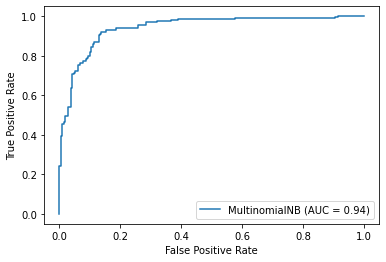

In [56]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(xtrain_tfidf,train_y)
# predict the labels
predictions_NB = Naive.predict(xtest_tfidf)
# Use accuracy_score function to get the accuracy of train
print("Naive Bayes accuracy score on test dataset is",accuracy_score( test_y, predictions_NB))
print("Naive Bayes accuracy score on training dataset is ", accuracy_score(train_y, Naive.predict(xtrain_tfidf)))
print("\nNaive Bayes confusion matrix \n", pd.DataFrame(confusion_matrix(test_y, predictions_NB),  index = ['True: 0', 'True: 1'], columns = ['Pred: 0', 'Pred: 1']))
print("\nClassification report \n",classification_report(test_y, predictions_NB))
print("\nFbeta score is ",fbeta_score(test_y, predictions_NB, average='weighted', beta=1.5))
print("Precision score is ",precision_score(test_y, predictions_NB))
print("Recall score is ",recall_score(test_y, predictions_NB))
metrics.plot_roc_curve(Naive, xtest_tfidf, test_y)


In [42]:
cv = model_selection.StratifiedKFold(n_splits = 3, shuffle = True, random_state = 2)

In [43]:
beta = 1.5

In [44]:
from sklearn.model_selection import cross_val_score
# Classifier - SVM
# fit the training dataset on the classifier
score = 0
c_optimal=0
degree_optimal =0
for c in [0.1, 0.2, 0.3, 0.4,0.5,0.6,0.7,0.8, 0.9,1]:
    for degree in [1,2,3]:
        
        SVM = svm.SVC(C=c, kernel='linear', degree=degree, gamma='auto', probability=True)
        score_precision = cross_val_score(SVM, xtrain_tfidf,train_y, cv=cv, scoring = 'precision').mean()
        score_recall = cross_val_score(SVM, xtrain_tfidf,train_y, cv=cv, scoring = 'recall').mean()
        fbeta_score_temp = (1+beta**2)*(score_precision *score_recall)/(beta**2 *score_precision+score_recall )     
        #print(fbeta_score)
        # predict the labels on validation dataset

        if fbeta_score_temp > score:
            score = fbeta_score_temp
            c_optimal = c
            degree_optimal = degree
        
print('optimal C = ', c_optimal, 'and optimal degree = ', degree, 'with Fbeta score = ', fbeta_score_temp)       
      

optimal C =  0.4 and optimal degree =  3 with Fbeta score =  0.89594083348478


SVM accuracy score on test dataset is  0.8967889908256881
SVM accuracy score on training dataset is  0.9491525423728814

SVM confusion matrix 
          Pred: 0  Pred: 1
True: 0      180       30
True: 1       15      211

Classification report 
               precision    recall  f1-score   support

           0       0.92      0.86      0.89       210
           1       0.88      0.93      0.90       226

    accuracy                           0.90       436
   macro avg       0.90      0.90      0.90       436
weighted avg       0.90      0.90      0.90       436


Fbeta score is  0.8963810289222123
Precision score is  0.8755186721991701
Recall score is  0.9336283185840708


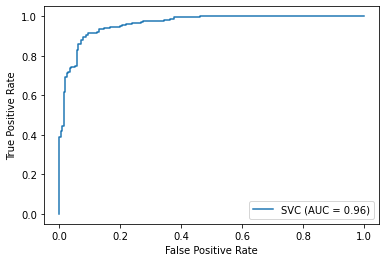

In [57]:
# Classifier - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=0.4, kernel='linear', degree=3, gamma='auto', probability=True)
SVM.fit(xtrain_tfidf,train_y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(xtest_tfidf)
# Use accuracy_score function to get the accuracy
print("SVM accuracy score on test dataset is ",accuracy_score( test_y,predictions_SVM))
#training score
print("SVM accuracy score on training dataset is ", accuracy_score(train_y, SVM.predict(xtrain_tfidf)))
print("\nSVM confusion matrix \n", pd.DataFrame(confusion_matrix(test_y, predictions_SVM),  index = ['True: 0', 'True: 1'], columns = ['Pred: 0', 'Pred: 1']))
print("\nClassification report \n",classification_report(test_y, predictions_SVM))
print("\nFbeta score is ",fbeta_score(test_y, predictions_SVM, average='weighted', beta=beta))
print("Precision score is ",precision_score(test_y, predictions_SVM))
print("Recall score is ",recall_score(test_y, predictions_SVM))
metrics.plot_roc_curve(SVM, xtest_tfidf, test_y)  

In [46]:


f_score = make_scorer(fbeta_score, beta=beta)

# define the model
model = RandomForestClassifier(n_estimators = 10, max_features = 1, oob_score = True, random_state = 45)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 60, stop = 300, num = 10)] 

# Minimum number of samples required to split a node
min_samples_split = [2,3,4,5,6,7,8,9, 10]

# Create the random grid
grid = {'n_estimators': n_estimators,
               'min_samples_split': min_samples_split}

clf = model_selection.GridSearchCV(RandomForestClassifier(), grid, cv = cv,scoring=f_score, error_score='raise')
clf.fit(xtrain_tfidf, train_y)
print('best score:', clf.best_score_)
print('best parameters: ', clf.best_params_)

best score: 0.9022376383839962
best parameters:  {'min_samples_split': 5, 'n_estimators': 60}


Random Forest accuracy score on test data is  0.8623853211009175
Random Forest accuracy score on training score /is  0.9954802259887006

Confusion matrix 
          Pred: 0  Pred: 1
True: 0      169       41
True: 1       19      207

Classification report 
               precision    recall  f1-score   support

           0       0.90      0.80      0.85       210
           1       0.83      0.92      0.87       226

    accuracy                           0.86       436
   macro avg       0.87      0.86      0.86       436
weighted avg       0.87      0.86      0.86       436


Fbeta score is  0.8614890842459292
Precision score is  0.8346774193548387
Recall score is  0.915929203539823


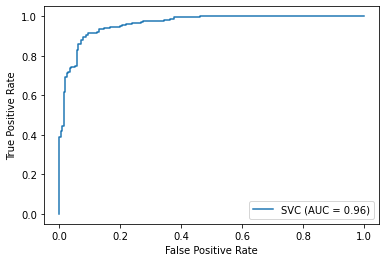

In [47]:
#Random Forest Model
rf = ensemble.RandomForestClassifier(random_state=45, min_samples_split= 10,max_features = 1,oob_score = True,  n_estimators = 140)
rf.fit(xtrain_tfidf, train_y)
predictions_rf = rf.predict(xtest_tfidf)
# Use accuracy_score function to get the accuracy
print("Random Forest accuracy score on test data is ",accuracy_score( test_y,predictions_rf))
print("Random Forest accuracy score on training score /is ", accuracy_score( train_y, rf.predict(xtrain_tfidf)))

print("\nConfusion matrix \n", pd.DataFrame(confusion_matrix(test_y, predictions_rf),  index = ['True: 0', 'True: 1'], columns = ['Pred: 0', 'Pred: 1']))
print("\nClassification report \n",classification_report(test_y, predictions_rf))
print("\nFbeta score is ",fbeta_score(test_y, predictions_rf, average='weighted', beta=beta))
print("Precision score is ",precision_score(test_y, predictions_rf))
print("Recall score is ",recall_score(test_y, predictions_rf))
metrics.plot_roc_curve(SVM, xtest_tfidf, test_y) 

In [48]:
# find the top 10 most representative words for each class

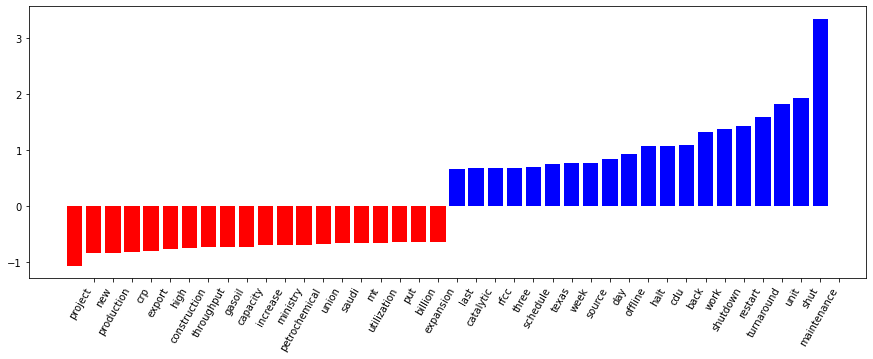

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
def plot_coefficients(classifier, feature_names, top_features=20): #choose 10
    coef = classifier.coef_.toarray().ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()
    
tfidf = TfidfVectorizer()
tfidf.fit(lemmas) 


SVM = svm.SVC(C=0.4, kernel='linear', degree=3, gamma='auto', probability=True)
SVM.fit(xtrain_tfidf,train_y)

plot_coefficients(SVM, tfidf.get_feature_names())

In [50]:
#Error analysis

In [51]:
check = pd.concat([pd.DataFrame((pd.DataFrame(test_x).index+1)),pd.DataFrame(predictions_SVM), pd.DataFrame(test_y)], axis =1)

In [52]:
check.columns = ['file_number', 'predicted_y', 'true_y']

In [53]:
#predict 1 but true label is 0. 
#false positive
np.sort(check['file_number'][check['predicted_y']>check['true_y']])

array([ 100,  102,  114,  116,  137,  209,  227,  228,  249,  269,  270,
        350,  354,  356,  407,  468,  479,  704,  717,  751,  781,  898,
        926,  935,  967,  969, 1039, 1216, 1315, 1318], dtype=int64)

In [54]:
#predict 0 but true label is 1. 
#false negative
np.sort(check['file_number'][check['predicted_y']<check['true_y']])

array([  96,   99,  201,  274,  527,  537,  573,  652,  732,  755,  812,
       1161, 1186, 1242, 1283], dtype=int64)